 # Objective: Build a machine learning model to predict Single Family Mortgage Defaut Probabilities


Dataset used: FNMA Single-Family Loan Performance Data. FNMA Mae releases data for Acquisition and Performance of loans every quarter. Q4 data for 2007 is used for this analysis. The dataset has two files:
- a) Aquisition file - The aquisition fie contains personal information for each of the borrowers, including an individual’s debt-to-income ratio, credit score, and loan amount, among several other things.
- b) Performance file - The perfomance data contains information regarding loan payment history, and whether or not a borrower ended up defaulting on their loan

[Click here for more information on the datset and variables](https://www.fanniemae.com/portal/funding-the-market/data/loan-performance-data.html)

### Summary of steps:
- a. Understand the dataset
- b. Literature review (Links are in the comments below)
- c. Data cleaning and transformation
- d. Sampling the data using imblearn - SMOTEENN
- e. Splitting the dataset
- f. Training and prediction using Random Forest model
- g. Check accuracy of prediction by passing the data to confusion matrix
- h. Check influence of the features on prediction
- i. Retrain the model with optimized parameters and important features

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

## Load datasets and add headers
[Link to Headers](https://loanperformancedata.fanniemae.com/lppub-docs/lppub_file_layout.pdf)

In [2]:
col_acq = ['LoanID','Channel','SellerName','OrInterestRate','OrUnpaidPrinc','OrLoanTerm',
        'OrDate','FirstPayment','OrLTV','OrCLTV','NumBorrow','DTIRat','CreditScore',
        'FTHomeBuyer','LoanPurpose','PropertyType','NumUnits','OccStatus','PropertyState',
        'Zip','MortInsPerc','ProductType','CoCreditScore','MortInsType','RelMortInd'];

col_per = ['LoanID','MonthRep','Servicer','CurrInterestRate','CAUPB','LoanAge','MonthsToMaturity',
          'AdMonthsToMaturity','MaturityDate','MSA','CLDS','ModFlag','ZeroBalCode','ZeroBalDate',
          'LastInstallDate','ForeclosureDate','DispositionDate','PPRC','AssetRecCost','MHRC',
          'ATFHP','NetSaleProceeds','CreditEnhProceeds','RPMWP','OFP','NIBUPB','PFUPB','RMWPF',
          'FPWA','ServicingIndicator'];

raw_acq = pd.read_csv('E:/DS Data/2007Q4/Acquisition_2007Q4.txt', sep='|', names=col_acq, index_col=False)
raw_per = pd.read_csv('E:/DS Data/2007Q4/Performance_2007Q4.txt', sep='|',
                     names=col_per, usecols=[0, 15], index_col=False)

In [3]:
print(raw_acq.head())
print(raw_per.head())

         LoanID Channel             SellerName  OrInterestRate  OrUnpaidPrinc  \
0  100002296854       C  BANK OF AMERICA, N.A.           6.625         343000   
1  100006876815       C  BANK OF AMERICA, N.A.           6.250         400000   
2  100008184591       B                  OTHER           6.625          81000   
3  100008870761       B           AMTRUST BANK           6.500         119000   
4  100013284158       B  BANK OF AMERICA, N.A.           6.625         205000   

   OrLoanTerm   OrDate FirstPayment  OrLTV  OrCLTV  ...  PropertyType  \
0         360  10/2007      12/2007     86    86.0  ...            PU   
1         360  10/2007      12/2007     62    62.0  ...            SF   
2         360  11/2007      01/2008     64    82.0  ...            SF   
3         360  11/2007      01/2008     71    71.0  ...            CO   
4         360  10/2007      12/2007     27    27.0  ...            SF   

   NumUnits  OccStatus PropertyState  Zip MortInsPerc  ProductType  \
0   

In [4]:
#Loan ID an ForeclosureDate are the only variables needed for training and prediction.
#Hence we drop all other variables from the data and merge it with aquisition file.
#Rename the Foreclosure field as 'Default' for easy reading

In [5]:
raw_per.drop_duplicates(subset='LoanID', keep='last', inplace=True)
raw_data = pd.merge(raw_acq, raw_per, on='LoanID', how='inner')

raw_data.rename(index=str, columns={"ForeclosureDate": 'Default'}, inplace=True)

In [6]:
#Default variables contains dates for records where the borrower defaulted and null values if not defaulted.
#These have to be convered to Binary values for the ML algorithmsto work properly

In [7]:
raw_data['Default'].fillna(0, inplace=True)
raw_data.loc[raw_data['Default'] != 0, 'Default'] = 1
raw_data['Default'] = raw_data['Default'].astype(int)

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391209 entries, 0 to 391208
Data columns (total 26 columns):
LoanID            391209 non-null int64
Channel           391209 non-null object
SellerName        391209 non-null object
OrInterestRate    391208 non-null float64
OrUnpaidPrinc     391209 non-null int64
OrLoanTerm        391209 non-null int64
OrDate            391209 non-null object
FirstPayment      391209 non-null object
OrLTV             391209 non-null int64
OrCLTV            391177 non-null float64
NumBorrow         391203 non-null float64
DTIRat            379728 non-null float64
CreditScore       390583 non-null float64
FTHomeBuyer       391209 non-null object
LoanPurpose       391209 non-null object
PropertyType      391209 non-null object
NumUnits          391209 non-null int64
OccStatus         391209 non-null object
PropertyState     391209 non-null object
Zip               391209 non-null int64
MortInsPerc       84925 non-null float64
ProductType       391209 non-null 

In [9]:
raw_data.head()

,LoanID,Channel,SellerName,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrDate,FirstPayment,OrLTV,OrCLTV,...,NumUnits,OccStatus,PropertyState,Zip,MortInsPerc,ProductType,CoCreditScore,MortInsType,RelMortInd,Default
0,100002296854,C,"BANK OF AMERICA, N.A.",6.625,343000,360,10/2007,12/2007,86,86.0,...,1,P,CO,809,25.0,FRM,756.0,2.0,N,0
1,100006876815,C,"BANK OF AMERICA, N.A.",6.250,400000,360,10/2007,12/2007,62,62.0,...,1,P,CA,920,NaN,FRM,790.0,NaN,N,0
2,100008184591,B,OTHER,6.625,81000,360,11/2007,01/2008,64,82.0,...,1,P,LA,708,NaN,FRM,NaN,NaN,N,0
3,100008870761,B,AMTRUST BANK,6.500,119000,360,11/2007,01/2008,71,71.0,...,1,P,IL,600,NaN,FRM,NaN,NaN,N,0
4,100013284158,B,"BANK OF AMERICA, N.A.",6.625,205000,360,10/2007,12/2007,27,27.0,...,1,P,CA,907,NaN,FRM,NaN,NaN,N,0


In [10]:
raw_data.describe()

,LoanID,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrLTV,OrCLTV,NumBorrow,DTIRat,CreditScore,NumUnits,Zip,MortInsPerc,CoCreditScore,MortInsType,Default
count,3.912090e+05,391208.000000,391209.000000,391209.000000,391209.000000,391177.000000,391203.000000,379728.000000,390583.000000,391209.000000,391209.000000,84925.000000,156239.000000,84925.000000,391209.000000
mean,5.504825e+11,6.481945,197361.852616,338.668111,72.172785,73.779760,1.523782,38.670606,720.122701,1.041967,513.973081,23.050056,728.572187,1.124616,0.090737
std,2.599792e+11,0.387415,101516.224863,56.802728,16.813497,17.122345,0.515925,12.508101,61.355206,0.257150,296.447887,6.480463,60.306947,0.330285,0.287235
min,1.000023e+11,3.970000,8000.000000,60.000000,1.000000,1.000000,1.000000,1.000000,392.000000,1.000000,6.000000,6.000000,390.000000,1.000000,0.000000
25%,3.251176e+11,6.250000,119000.000000,360.000000,64.000000,65.000000,1.000000,30.000000,673.000000,1.000000,280.000000,17.000000,683.000000,1.000000,0.000000
50%,5.506809e+11,6.500000,180000.000000,360.000000,78.000000,80.000000,2.000000,39.000000,725.000000,1.000000,486.000000,25.000000,739.000000,1.000000,0.000000
75%,7.755272e+11,6.750000,260000.000000,360.000000,80.000000,87.000000,2.000000,48.000000,774.000000,1.000000,787.000000,25.000000,781.000000,1.000000,0.000000
max,9.999996e+11,9.375000,802000.000000,360.000000,97.000000,143.000000,10.000000,64.000000,843.000000,4.000000,999.000000,39.000000,844.000000,2.000000,1.000000


In [11]:
# Check for missing values
raw_data.isnull().sum()

LoanID                 0
Channel                0
SellerName             0
OrInterestRate         1
OrUnpaidPrinc          0
OrLoanTerm             0
OrDate                 0
FirstPayment           0
OrLTV                  0
OrCLTV                32
NumBorrow              6
DTIRat             11481
CreditScore          626
FTHomeBuyer            0
LoanPurpose            0
PropertyType           0
NumUnits               0
OccStatus              0
PropertyState          0
Zip                    0
MortInsPerc       306284
ProductType            0
CoCreditScore     234970
MortInsType       306284
RelMortInd             0
Default                0
dtype: int64

In [12]:
#'MortInsPerc' and  'CoCreditScore' are missing in nearly 85% of the records and around 70% records do not have 'MortInsType'.
#Imputing is not an option, these variables should be dropped.
# CreditScore,DTIRat, OrCLTV, OrInterestRate are missing for some samples. dropping these samples should not affect predictions.
# There is a huge class imbalance in the target variable. This has to be addressed during data samping .

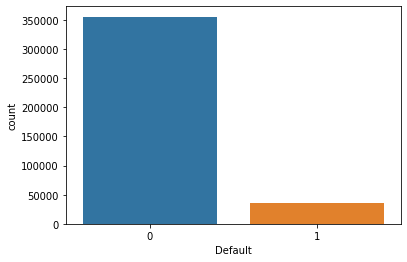

In [13]:
sns.countplot(raw_data['Default'])

## Basic Exploratory Analysis to look for patterns

In [14]:
# On average, defaulters have a higher debt-to-income ratio, lower credit scores, and borrowed at higher interest rates.

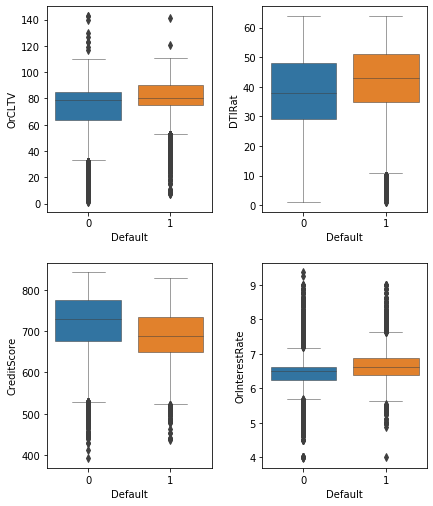

In [15]:
columns = ['OrCLTV','DTIRat','CreditScore','OrInterestRate']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6,7))
plt.tight_layout(w_pad=2.0, h_pad=3.0)

for i, column in zip(range(1,5), columns):
    plt.subplot(2,2,i)
    sns.boxplot(x="Default", y=column, data=raw_data, linewidth=0.5)
    plt.xlabel('Default')

In [16]:
#Borrowers from Arizona (zip 852 and 853) are more likely to default than borrowers from Texas

Text(0.5, 1.0, 'Top 10 defaulters by ZIP code')

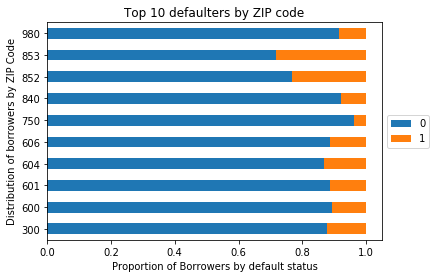

In [17]:
data = raw_data.loc[raw_data['Zip'].isin(raw_data['Zip'].value_counts().index.tolist()[:10])]

xtab = pd.pivot_table(data, index='Zip', columns='Default', aggfunc='size')
xtab = xtab.div(xtab.sum(axis=1), axis=0)
xtab.plot.barh(stacked=True, figsize=(6,4))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('Proportion of Borrowers by default status')
plt.ylabel('Distribution of borrowers by ZIP Code')
plt.title('Top 10 defaulters by ZIP code')

## Data Cleaning and Transformation

In [18]:
#split date variables into their respective months and year components ( just in case we decide to dig deeper)

In [19]:
df = raw_data.copy()
df['OrDateMonth'] = df['OrDate'].apply(lambda x: x.split('/')[0].strip()).astype(int)
df['OrDateYear'] = df['OrDate'].apply(lambda x: x.split('/')[1].strip()).astype(int)

df['FirstMonth'] = df['FirstPayment'].apply(lambda x: x.split('/')[0].strip()).astype(int)
df['FirstYear'] = df['FirstPayment'].apply(lambda x: x.split('/')[1].strip()).astype(int)

df.drop(['OrDate','FirstPayment'], axis=1, inplace=True)

In [20]:
# Drop variables with missing values/ that are not necessary
df.drop(['MortInsPerc','MortInsType','CoCreditScore','ProductType','LoanID'], axis=1, inplace=True)

In [21]:
#Create dummies for categorical variables
def getdummies(df):
    columns = df.columns[df.isnull().any()]
    nan_cols = df[columns]

    df.drop(nan_cols.columns, axis=1, inplace=True)

    cat = df.select_dtypes(include=['object'])
    num = df.drop(cat.columns, axis=1)

    data = pd.DataFrame()
    for i in cat.columns:
        tmp = pd.get_dummies(cat[i], drop_first=True)
        data = pd.concat([data, tmp], axis=1)

    df = pd.concat([num,data,nan_cols], axis=1).reset_index(drop=True)
    return df

In [22]:
#Drop samples with null values in any row 
df = df.dropna(how='any',axis=0)

In [23]:
df = getdummies(df)
df.to_csv('E:/DS Data/cleaned_Q42007.csv')

## Sampling
Over sampling the minority class and under-sampling the majority class using
SMOTE and Edited Nearest Neighbours' to balance class imbalance

In [24]:
from imblearn.combine import SMOTEENN
sm = SMOTEENN()
y = df['Default'].values
X = df.drop(['Default'], axis=1).values
X_resampled, y_resampled = sm.fit_sample(X, y)

## Splitting the data into training and test datasets

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.25, random_state=0)

## Train the Random Forest Model 

In [26]:
#Train Random Forest Classifier and predict
model = RandomForestClassifier(n_estimators=200)
model = model.fit(X_train, y_train)
predict = model.predict(X_test)

# Evaluation of the model
The model acheived an accurcy score of 95%;

Recall scores of 98% and 94% ( meaning less losses to the FNMA)

Precision score of 92% and 98% (less hassles to borrowers due to misclassification)

In [34]:
# Print classification report
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     55165
           1       0.98      0.94      0.96     76153

    accuracy                           0.95    131318
   macro avg       0.95      0.96      0.95    131318
weighted avg       0.96      0.95      0.95    131318



(1.7, 0.3)

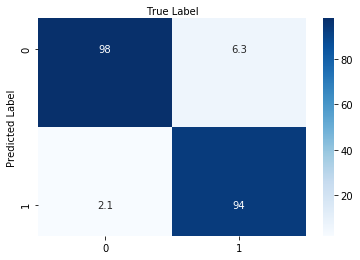

In [33]:
# Plot the results using confusion matrix
cm = confusion_matrix(y_test, predict).T
cm = cm.astype('float')/cm.sum(axis=0)*100

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.xaxis.set_label_position('top')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.2, top - 0.2)

AUC-ROC curve is one of the most commonly used metrics to evaluate the performance of machine learning algorithms particularly in the cases where we have imbalanced datasets.

The dotted line represents a completely uninformative test, which corresponds to an AUC of 0.5. A curve pulled close to the upper left corner indicates (an AUC close to 1 and thus) a better performing test.

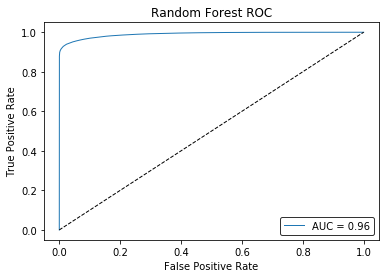

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = roc_auc_score(y_test, predict)

plt.plot(fpr, tpr, lw=1, label='AUC = %0.2f'%(roc_auc))
plt.plot([0, 1], [0, 1], '--k', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC')
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

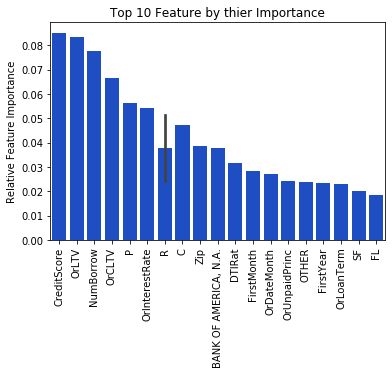

In [30]:
feature_labels = df.drop('Default', axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
ncomp = 20
sns.barplot(x=feature_labels[indices[:ncomp]], y=importances[indices[:ncomp]], color =sns.xkcd_rgb["blue"])
plt.title('Top 10 Feature by thier Importance')
plt.ylabel('Relative Feature Importance')
plt.xticks(rotation=90)

Credit score, Original Combined Loan to value and number of borrowers are among the important features that influence prediction

## Future work

Analyse Loss severity by computing loss statistics:
- Delinquent Interest Expense (Default UPB * ((Current Interest Rate/100 – 0.0035)/12) * months from LPI to disposition)
- Total Costs (Foreclosure Costs + Property Preservation and Repair Costs + Asset Recovery Costs + Miscellaneous Holding Expenses and Credits + Associated Taxes for Holding Property)
- Total Proceeds (Defaulted UPB + Accrued Interest + Total Costs – Total Proceeds)
- Severity (Total Net Loss / Defaulted UPB)

# Conclusion

The model acheived an accuracy score of 95% on the test data set which is great. Performance of this model on a real data stream with no samping needs to be seen.